In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [30]:
#Function to generate a grid of coordinates in numpy
#Resulting grid is indexed [coordinate, (x or y)][x grid position][y grid position]
def GenerateEqualSpaced2dGridCoordinates(grid_size,grid_dimension):
    #Single axis coordinate ticks, we only use square grids, just an ascending list
    GeneratingAxis = np.array(list(range(0,grid_size)))
    
    #Build an array of appropriate size, square of grid points, each point has 2! values, its x coordinate, and y coordinate
    CoordinateField = np.zeros((2,GeneratingAxis.size, GeneratingAxis.size))
    
    #Iterate each gridpoint, and fill in its position values
    for cx, iy, ix in np.ndindex(CoordinateField.shape):
        CoordinateField[0][ix][iy] = (ix - grid_size // 2) * grid_dimension / grid_size#Write x coordinate
        CoordinateField[1][ix][iy] = (iy - grid_size // 2) * grid_dimension / grid_size#Write y coordinate
        
    #Return the grid
    return CoordinateField


In [31]:
mm = 10**-3
nm =  10 **-9
GridSize = 256
GridDimension = 8 * mm
BeamDimension = 1 * mm
freq_spacing = 2*np.pi*GridSize/GridDimension
lamb = 532 * nm
#Generate an example grid, GridsizexGridsize grid points
gridcoords = GenerateEqualSpaced2dGridCoordinates(GridSize,GridDimension)

In [32]:
#Find the distance of each grid coordinate to a set location c, if c is not specified, just choose the center
#of the provided grid
def GridCoordinatesToDistances(x,c = "NaN"):
    if c == "NaN":
        #c not provided by user, just pick the center of the grid
        c = (x[0][x.shape[1] // 2][0] , x[1][0][x.shape[2] // 2])
    xp = x[0] - c[0]
    yp = x[1] - c[1]
    #D = v((x-c_x)^2 + (y-c_y)^2) 
    #Apply the distance formula on all grid points
    return np.sqrt(np.sum(np.square(np.array([xp,yp])),axis = 0))

In [33]:
#Generate example distances
distances = GridCoordinatesToDistances(gridcoords)

In [34]:
#Take in some grid coordinates, and output a 2d gaussian, whos square integral is one, and whose width is sigma
#(same idea as normalization in quantum mechanics)

def NormalizedGaussian(coordinates, sigma):
    #The gaussian falls as the distance to its center squared, with rate scaling by sigma, the distribution width
    unnormalized_gaussian = np.exp(-(GridCoordinatesToDistances(coordinates)/sigma)**2)
    
    #Return the gaussian, but normalized
    return unnormalized_gaussian/np.sqrt(np.sum(np.square(unnormalized_gaussian)))
    

In [35]:
#Take a grid of complex numbers (can represent a laser beam cross section), and give a 
#plot of its intensity
def PlotAmplitudeIntensity(twod_field):
    #Note the intensity is the square of the complex magnitude. The E/B field squared
    #gives energy density
    plt.imshow(np.square(np.abs(twod_field)))
    plt.colorbar()

#Generate an example Gaussian laser field
ideal_laser_beam_field = NormalizedGaussian(gridcoords, BeamDimension)



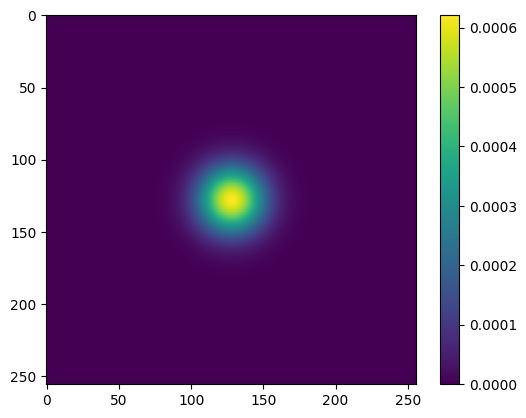

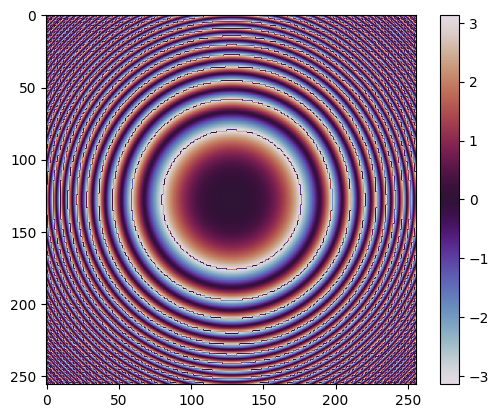

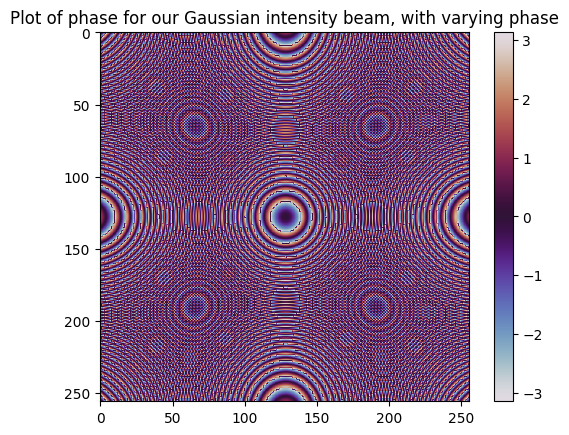

0.0009999999999999588


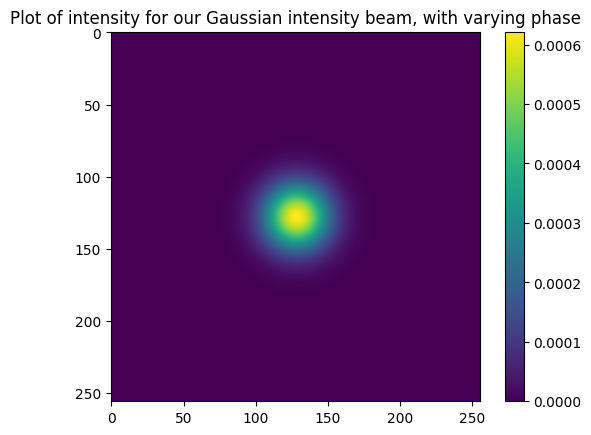

In [87]:
#We want to add phase to our Gaussian beam, to model non-ideal lasers
def PlotAmplitudePhase(twod_field):
    #Note: cmap = "twilight", this is a cyclic color map, which is useful when the plotted value is cyclic
    #(like the phase of a complex number) Notice how the color repeats for +/- pi
    #We set the limits of our phase plot to +/- pi, this represents the full unit circle
    plt.imshow(np.angle(twod_field), cmap = "twilight", vmin = -1.0 * np.pi, vmax = 1 * np.pi)
    plt.colorbar()
    
#Multiply a radial phase on the beam, "np.exp(i * distance / ...[scaling])" makes the phase vary with radius
#in python we write complex numbers as a + bj, instead of a + bi like in physics
#Multiplying by a phase exp(ix) where x is arbitrary does not spoil normalization, since exp(ix) has complex
#magnitude of 1.0
final_field = ideal_laser_beam_field * np.exp(0.5j * np.pi/lamb/(400*mm)/GridDimension * distances**3)
PlotAmplitudeIntensity(final_field)
plt.show()
PlotAmplitudePhase(final_field)
plt.show()
final_field = final_field * np.exp(-1.0j * np.pi/lamb/(200*mm) * distances**2)
#Show phase of the new field using our function
plt.title("Plot of phase for our Gaussian intensity beam, with varying phase")
PlotAmplitudePhase(final_field)
plt.show()
plt.title("Plot of intensity for our Gaussian intensity beam, with varying phase")
PlotAmplitudeIntensity(final_field)
outx = np.sum(np.square(np.abs(final_field)), axis = 1)/np.sum(np.square(np.abs(final_field)))
outy = np.sum(np.square(np.abs(final_field)), axis = 0)/np.sum(np.square(np.abs(final_field)))
m1x = np.sum(outx*gridcoords[0,:,0])
m1y = np.sum(outy*gridcoords[0,:,0])

m2y = np.sum(outy*np.square((gridcoords[0,:,0] - m1y)))
m2x = np.sum(outx*np.square((gridcoords[0,:,0] - m1x)))

print(2*np.sqrt(m2x))

In [88]:
conv_grid = 225
gridcoords2 = GenerateEqualSpaced2dGridCoordinates(conv_grid,GridDimension/GridSize * conv_grid)
distances2 = GridCoordinatesToDistances(gridcoords2)

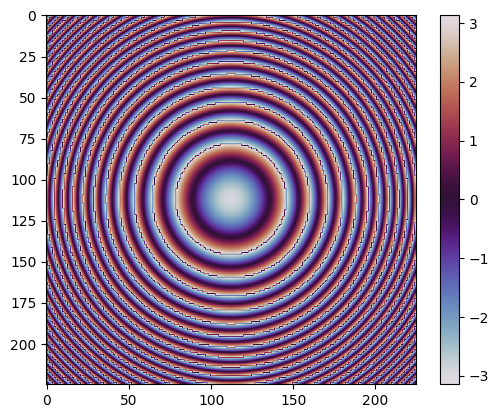

In [89]:
z = 170 * mm
kernel = np.exp(1.0j*z/lamb)/(1.0j*lamb*z)*np.exp(1.0j/lamb/(2*z)*np.square(distances2[:,:]))
PlotAmplitudePhase(kernel)

In [90]:
out =final_field# sp.signal.convolve2d(,kernel,mode = "full")

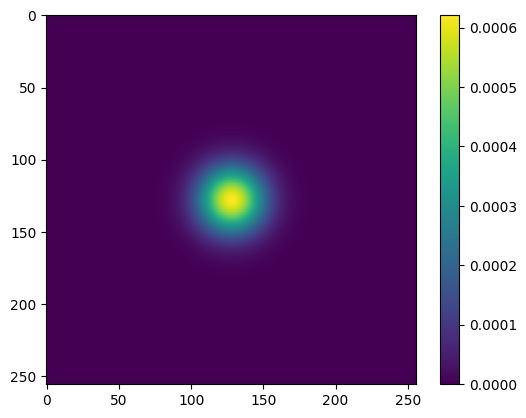

In [91]:
PlotAmplitudeIntensity(out)

In [ ]:

PlotAmplitudeIntensity(out)
plt.show()
out = sp.signal.convolve2d(out,kernel,mode = "same")
print(np.sum(np.abs(np.square(out))))


PlotAmplitudeIntensity(out)
plt.show()

In [ ]:
widths = []
zs = []
for i in range(30,60):
    z = i * 10 * mm

    zs.append(z)
    kernel = np.exp(1.0j*2*np.pi*z/lamb)/(1.0j*lamb*z)*np.exp(1.0j*2*np.pi/lamb/(2*z)*np.square(distances2[:,:]))
    out = cv2.filter2D(src=final_field,ddepth=-1,kernel = kernel)#kernel,mode = "same")/np.sqrt(np.sum(np.abs(np.square(out))))
    out = out/np.sqrt(np.sum(np.abs(np.square(out))))
    outx = np.sum(np.square(np.abs(out)), axis = 1)/np.sum(np.square(np.abs(out)))
    outy = np.sum(np.square(np.abs(out)), axis = 0)/np.sum(np.square(np.abs(out)))
    #print(np.sum(np.abs(np.square(out))))


    #PlotAmplitudeIntensity(out)
    plt.plot(outx)
    #c0 = sp.stats.moment(np.square(np.abs(out)), moment=1, axis=0, nan_policy='propagate')
    #c1 = sp.stats.moment(np.square(np.abs(out)), moment=1, axis=1, nan_policy='propagate' )
    np.sum(outx*gridcoords[0,:,0])/np.sum(outx)
    m1x = np.sum(outx*gridcoords[0,:,0])
    m1y = np.sum(outy*gridcoords[0,:,0])
    
    m2y = np.sum(outy*np.square((gridcoords[0,:,0] - m1y)))
    m2x = np.sum(outx*np.square((gridcoords[0,:,0] - m1x)))
    widths.append(2*np.sqrt(m2x))
    plt.title(str(np.sum((outx)))+"    "+str(m2x) + "   " + str(m2y) )
    plt.show()

In [ ]:
print(np.max(gridcoords))
1/256

In [119]:
import time
star = time.time_ns()
widths = []
zs = []
N = 0
N_samples = 60
for i in range(N-N_samples//2,N+N_samples//2):
    print(np.abs(i)/2, "%")
    z = 0.5 *mm+ 200*mm + i/ N_samples/2 *100  * 3 * mm
    FT_m = np.fft.fftshift(np.fft.fft2(final_field * np.exp(1.0j*2*np.pi/lamb/(2*z)*np.square(distances[:,:]))),axes=(0,1))#np.roll(np.roll(np.fft.fft2(final_field * np.exp(1.0j*2*np.pi/lamb/(2*z)*np.square(distances[:,:]))),GridSize//2, axis = 1),GridSize//2,axis = 0)
    #plt.imshow(np.abs(np.square(FT_m)))
    #plt.title("FFT")
    #plt.show()
    zs.append(z)
    #kernel = np.exp(1.0j*2*np.pi*z/lamb)/(1.0j*lamb*z)*np.exp(1.0j*2*np.pi/lamb/(2*z)*np.square(distances2[:,:]))
    #out = cv2.filter2D(src=final_field,ddepth=-1,kernel = kernel)#kernel,mode = "same")/np.sqrt(np.sum(np.abs(np.square(out))))
    out = FT_m
    #out = out/np.sqrt(np.sum(np.abs(np.square(out))))
    
    outx = np.sum(np.square(np.abs(out)), axis = 1)/np.sum(np.square(np.abs(out)))

    outy = np.sum(np.square(np.abs(out)), axis = 0)/np.sum(np.square(np.abs(out)))
    #print(np.sum(np.abs(np.square(out))))


    #PlotAmplitudeIntensity(out)
    #plt.show()
    #plt.plot(outx)
    #c0 = sp.stats.moment(np.square(np.abs(out)), moment=1, axis=0, nan_policy='propagate')
    #c1 = sp.stats.moment(np.square(np.abs(out)), moment=1, axis=1, nan_policy='propagate' )
    np.sum(outx*gridcoords[0,:,0])/np.sum(outx)
    sf = GridSize/(GridDimension**2)*lamb*z
    newc = (gridcoords[0,:,0]) * sf
    m1x = np.sum(outx*newc)
    m1y = np.sum(outy*newc)
    
    m2y = np.sum(outy*np.square(newc - m1y))
    m2x = np.sum(outx*np.square(newc - m1x))
    
    
    widths.append(2*np.sqrt(m2x))
    #plt.title(str(np.sum((outx)))+"    "+str(m2x) + "   " + str(m2y) )
    #plt.show()
end = time.time_ns()
print(round((end-star)/10**9 * 1000,1), "ms, to run 1 instance, ",round((end-star)/10**9 * 1000,1), "seconds to run 1,000")

15.0 %
14.5 %
14.0 %
13.5 %
13.0 %
12.5 %
12.0 %
11.5 %
11.0 %
10.5 %
10.0 %
9.5 %
9.0 %
8.5 %
8.0 %
7.5 %
7.0 %
6.5 %
6.0 %
5.5 %
5.0 %
4.5 %
4.0 %
3.5 %
3.0 %
2.5 %
2.0 %
1.5 %
1.0 %
0.5 %
0.0 %
0.5 %
1.0 %
1.5 %
2.0 %
2.5 %
3.0 %
3.5 %
4.0 %
4.5 %
5.0 %
5.5 %
6.0 %
6.5 %
7.0 %
7.5 %
8.0 %
8.5 %
9.0 %
9.5 %
10.0 %
10.5 %
11.0 %
11.5 %
12.0 %
12.5 %
13.0 %
13.5 %
14.0 %
14.5 %
236.5 ms, to run 1 instance,  236.5 seconds to run 1,000


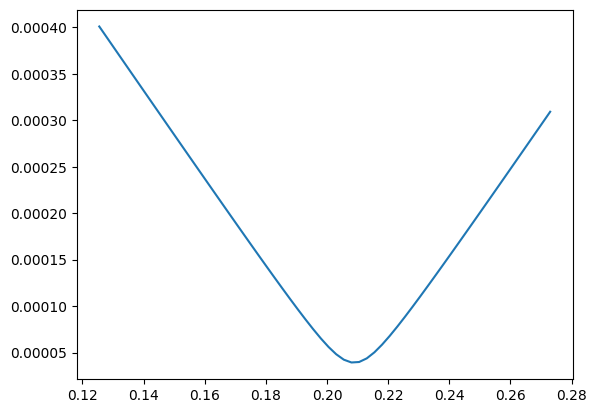

In [120]:
plt.plot(zs,widths)

In [121]:
def width(z,z0,w0,Msq):
    return np.sqrt(w0**2 + Msq**2 *np.square(lamb/np.pi/w0)*np.square(z-z0))
    
fit = sp.optimize.curve_fit(width, zs[:], np.array(widths[:]), p0 = [.45,.001,1.0])

In [122]:
fit[0]

array([2.08897849e-01, 3.91513847e-05, 1.10590572e+00])

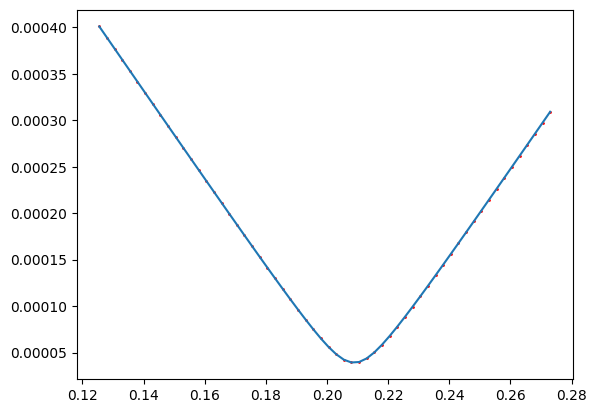

In [123]:
plt.scatter(zs[:],np.array(widths[:]), c= "r", s = 1)
plt.plot(zs,width(zs,fit[0][0],fit[0][1],fit[0][2]))